In [392]:
# Data Wrangling & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Validation
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix

### Data Collection & Processing

In [3]:
# Download dataset
# ! wget https://raw.githubusercontent.com/EricChiang/churn/master/data/churn.csv
# ! mkdir data
# ! mv churn.csv ./data/churn.csv

In [283]:
# Creating churn dataframe
churn = pd.read_csv('data/churn.csv')

In [284]:
# Column name cleanup
churn.rename(columns = {'Churn?': 'Churn'}, inplace=True)
churn.rename(columns = {"Int'l Plan":"Intl Plan"}, inplace=True)

In [285]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Intl Plan         3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 572.9+ KB


In [286]:
churn.head(2)

,State,Account Length,Area Code,Phone,Intl Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [287]:
# Binarizing all columns at once
churn.replace('no', 0, inplace=True)
churn.replace('yes', 1, inplace=True)
churn.replace('False.', 0, inplace=True)
churn.replace('True.', 1, inplace=True)

In [288]:
# Dropping columns
drop_cols = ['Area Code', 'Phone', 'State']
churn.drop(drop_cols, axis=1, inplace=True)

In [289]:
# Setting up for modeling
y = churn.Churn
churn.drop("Churn", axis=1, inplace=True)
X = churn
columns = X.columns

### Exploratory Data Analysis

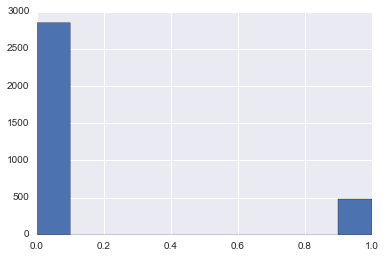

In [22]:
# Unbalanced classes
churn.Churn.hist();

In [23]:
churn.groupby('Churn')['Churn'].count()

Churn
0    2850
1     483
Name: Churn, dtype: int64

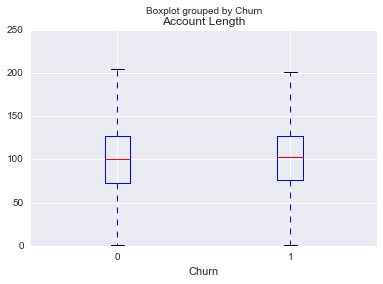

In [24]:
# No extreme churn distribution shift by account length
churn.boxplot(column='Account Length', by='Churn');

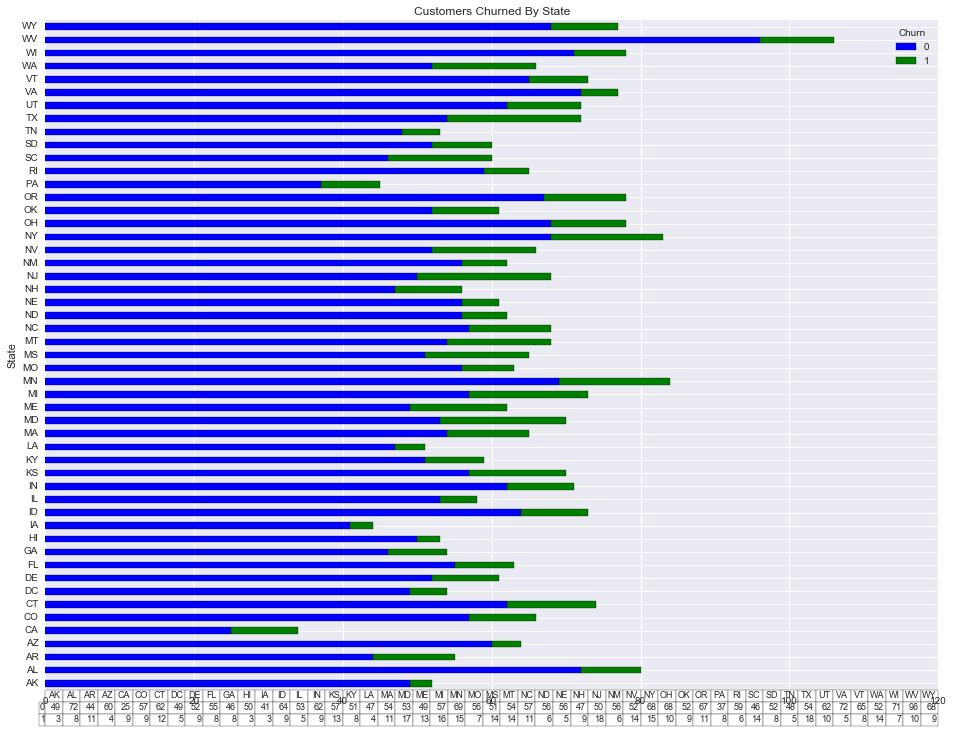

In [25]:
churn2 = churn.groupby(['State','Churn'])['Churn'].count().unstack()
churn2.plot(kind='barh',stacked=True, figsize=(16,12), title='Customers Churned By State', table=True);

In [108]:
churn_subset1 = churn[['Account Length', 'Intl Plan', 'VMail Plan', 'CustServ Calls', 'Churn']]

In [109]:
churn_subset2 = churn[['Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', \
                       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', \
                      'Intl Calls', 'Intl Charge', 'Churn']]

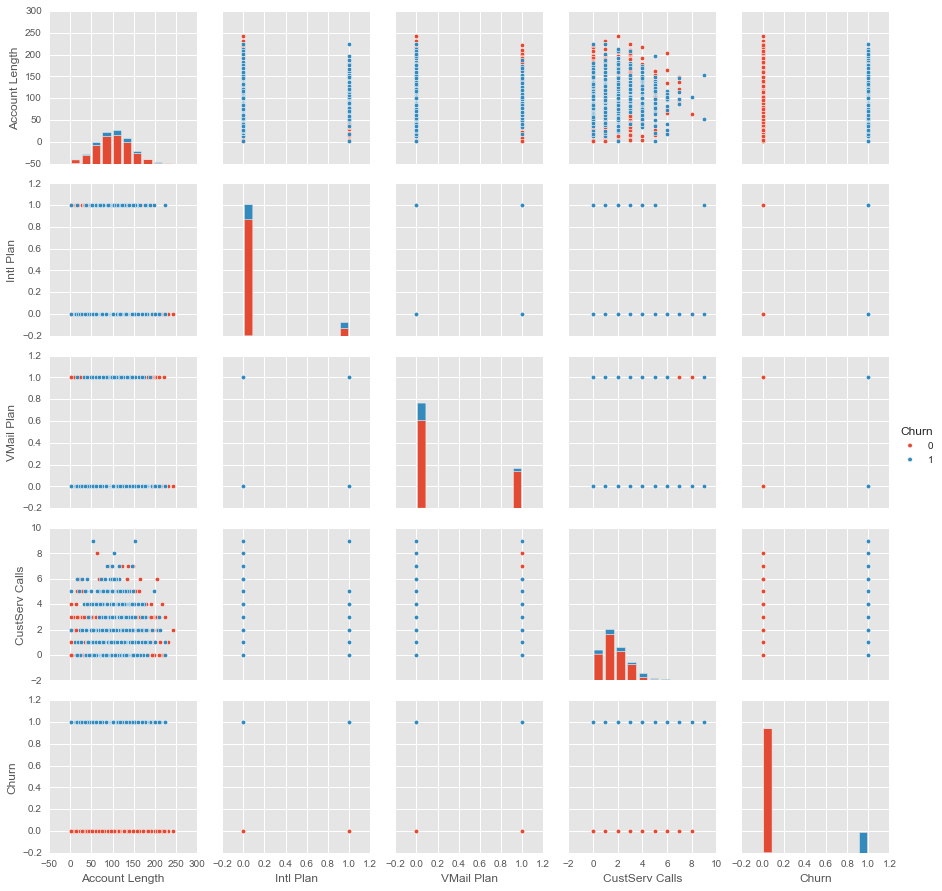

In [112]:
sns.pairplot(churn_subset1, hue='Churn');

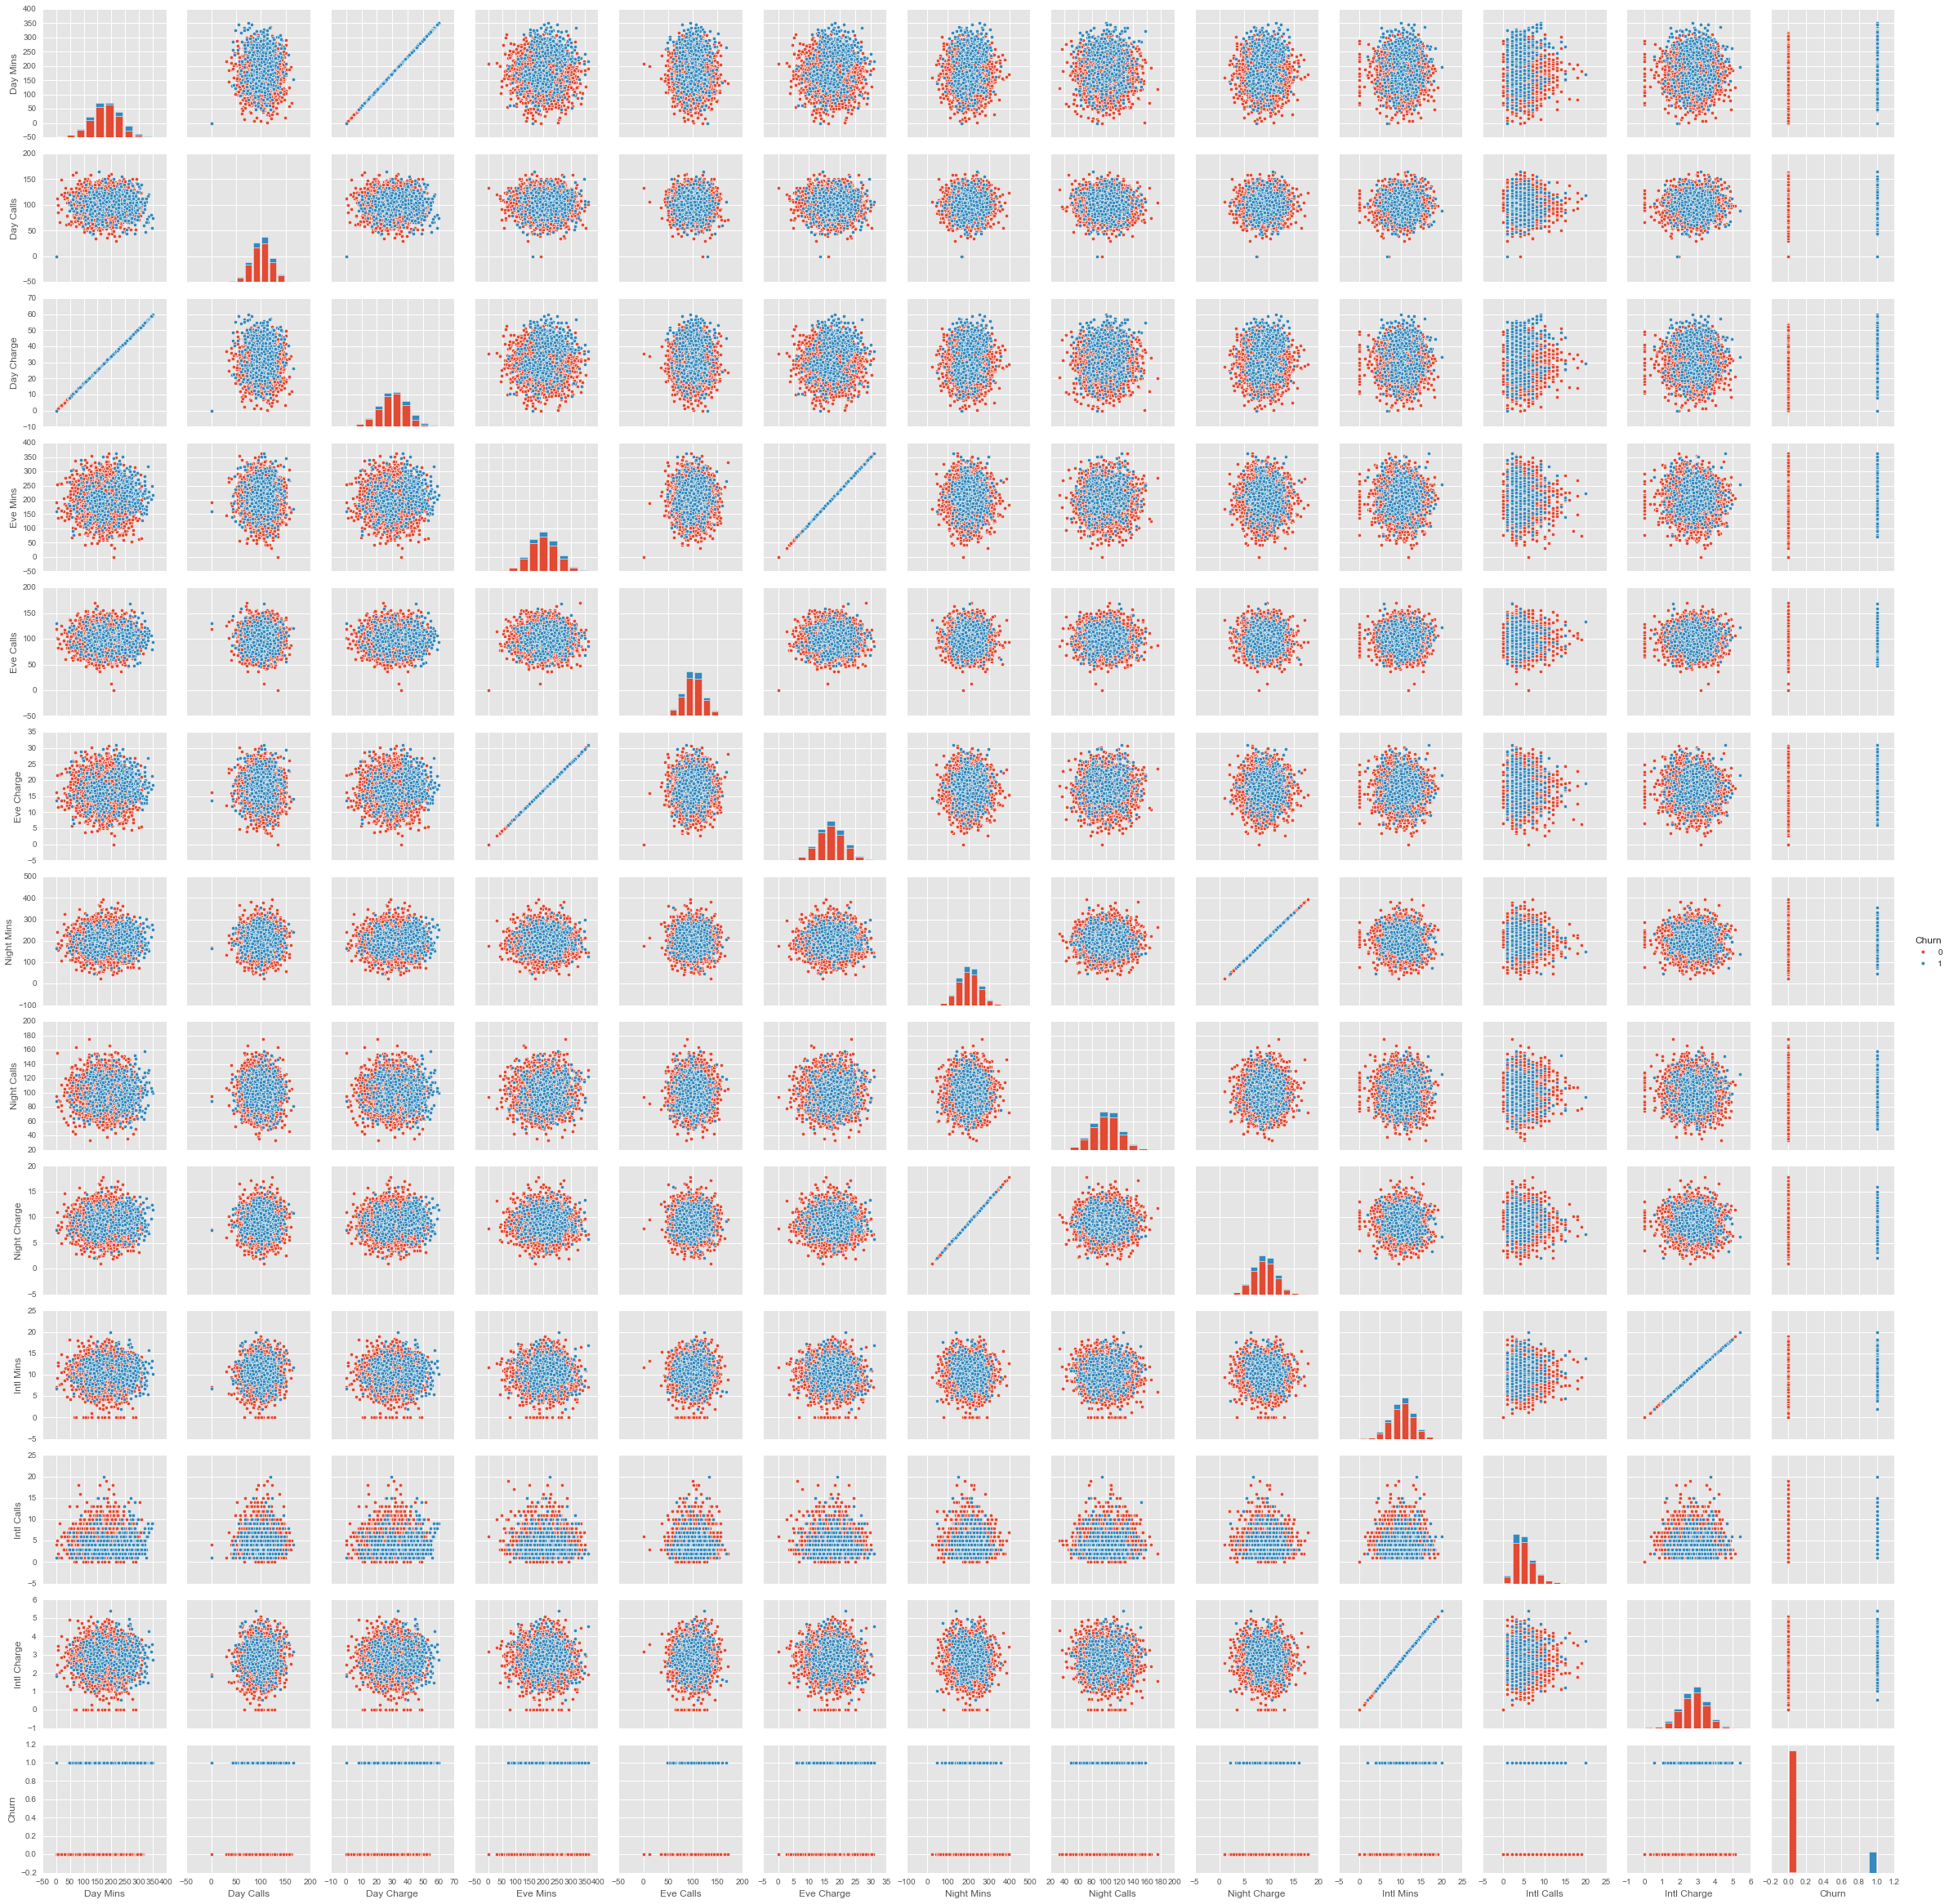

In [113]:
sns.pairplot(churn_subset2, hue='Churn');

### Logistic Regression

In [404]:
X_statmodel = sm.add_constant(X)
y_statmodel = y.copy()

In [119]:
cols = " + ".join(churn.columns.difference(['Churn']))

In [120]:
formula1 = "Churn ~ " + cols

In [121]:
# model = sm.Logit(y, X).fit()
model = smf.ols(formula = formula1, data = churn)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
model.summary()

In [405]:
logit = LogisticRegression()

In [406]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [407]:
logit.score(X_test, y_test)

0.85757121439280359

### Feature Engineering

### Modeling

In [290]:
scaler = StandardScaler()

In [291]:
X.columns

Index([u'Account Length', u'Intl Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')

In [317]:
X = scaler.fit_transform(X)

In [ ]:
# Thinking Logistic Regression, Random Forest / other tree-based model because of mixed feature types, and one-class
# SVMs due to unbalanced class issue

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
rf.score(X_test, y_test)

0.94602698650674666

In [395]:
def trees_featureImportances(X, y, model, **kwargs):
    """Returns Feature Importances on Tree-based Classifiers along with visualization"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    classifier = model(**kwargs)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    feature_importances = classifier.feature_importances_
    feature_ranks = np.argsort(feature_importances)[::-1]
    rank_std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    
    plt.figure(figsize=(16,8))
    plt.bar(np.arange(X.shape[1]), feature_importances[feature_ranks], yerr= rank_std[feature_ranks], color='r')
    plt.xticks(np.arange(X.shape[1]) + 0.25, columns[feature_ranks], rotation=45)
    plt.title('Features by Predictive Importance')
    plt.ylabel('Relative Feature Importance');
    
    print "Accuracy: {:.3f}".format(score)
    print "Feature Importances: "
    for f in range(X.shape[1]):
        print "Feature {}: {}, Relative Importance {:.3f}, Std: {:.3f}".format(f+1, columns[feature_ranks[f]], feature_importances[feature_ranks[f]], rank_std[feature_ranks[f]])

Accuracy: 0.942
Feature Importances: 
Feature 1: Day Charge, Relative Importance 0.146, Std: 0.060
Feature 2: Day Mins, Relative Importance 0.138, Std: 0.057
Feature 3: CustServ Calls, Relative Importance 0.128, Std: 0.033
Feature 4: Intl Plan, Relative Importance 0.067, Std: 0.030
Feature 5: Eve Charge, Relative Importance 0.066, Std: 0.019
Feature 6: Intl Calls, Relative Importance 0.057, Std: 0.029
Feature 7: Eve Mins, Relative Importance 0.053, Std: 0.021
Feature 8: Intl Charge, Relative Importance 0.051, Std: 0.026
Feature 9: Night Charge, Relative Importance 0.038, Std: 0.015
Feature 10: Intl Mins, Relative Importance 0.037, Std: 0.024
Feature 11: Night Mins, Relative Importance 0.036, Std: 0.020
Feature 12: Account Length, Relative Importance 0.034, Std: 0.008
Feature 13: Day Calls, Relative Importance 0.033, Std: 0.011
Feature 14: VMail Message, Relative Importance 0.030, Std: 0.018
Feature 15: Night Calls, Relative Importance 0.029, Std: 0.012
Feature 16: Eve Calls, Relative I

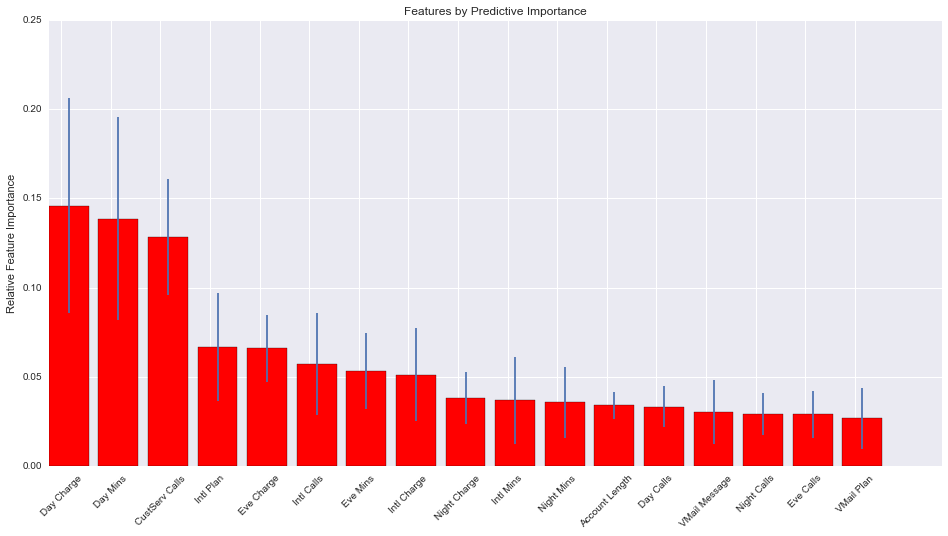

In [396]:
trees_featureImportances(X,y, RandomForestClassifier)

Accuracy: 0.918
Feature Importances: 
Feature 1: Day Mins, Relative Importance 0.133, Std: 0.043
Feature 2: Day Charge, Relative Importance 0.132, Std: 0.040
Feature 3: CustServ Calls, Relative Importance 0.125, Std: 0.009
Feature 4: Intl Plan, Relative Importance 0.069, Std: 0.002
Feature 5: Eve Charge, Relative Importance 0.061, Std: 0.007
Feature 6: Eve Mins, Relative Importance 0.057, Std: 0.010
Feature 7: Intl Mins, Relative Importance 0.053, Std: 0.013
Feature 8: Intl Calls, Relative Importance 0.050, Std: 0.013
Feature 9: Intl Charge, Relative Importance 0.047, Std: 0.011
Feature 10: Night Mins, Relative Importance 0.043, Std: 0.010
Feature 11: Day Calls, Relative Importance 0.043, Std: 0.008
Feature 12: Night Charge, Relative Importance 0.042, Std: 0.011
Feature 13: Night Calls, Relative Importance 0.041, Std: 0.009
Feature 14: Account Length, Relative Importance 0.041, Std: 0.011
Feature 15: Eve Calls, Relative Importance 0.036, Std: 0.009
Feature 16: VMail Message, Relative I

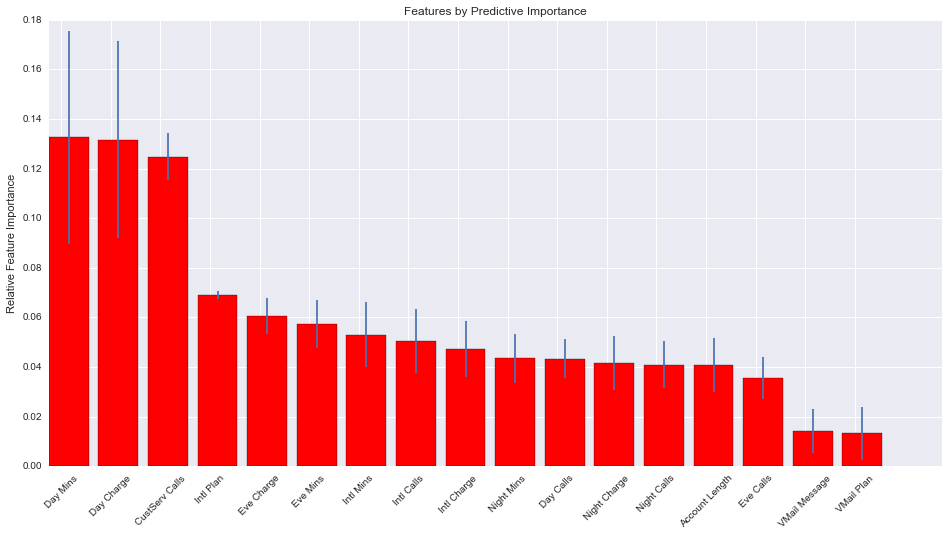

In [399]:
trees_featureImportances(X,y, ExtraTreesClassifier)

In [168]:
def model_predict(X, y, model, **kwargs):
    kf = KFold(len(y), n_folds=10, shuffle=True)
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier = model(**kwargs)
        classifier.fit(X_train, y_train)
        pred_y = classifier.predict(X_test)
        score = classifier.score(X_test, y_test)
        return score

In [170]:
model_predict(X, y, RandomForestClassifier)

0.93413173652694614

In [171]:
model_predict(X, y, svm.SVC)

0.91916167664670656

### Validation

In [402]:
rf_cm = confusion_matrix(y_test, pred)

In [401]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(y))
    plt.xticks(tick_marks, y.columns, rotation=45)
    plt.yticks(tick_marks, y.columns)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

AttributeError: 'Series' object has no attribute 'columns'

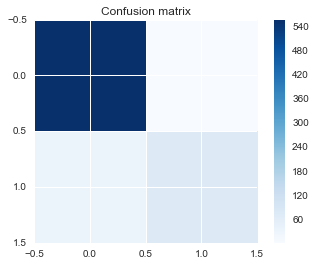

In [403]:
plot_confusion_matrix(rf_cm)

### Churn Measurements

In [ ]:
class Churn_Model(object):
    def __init__(self):
    def customer
    def predict
    def score

In [ ]:
def profit_lost():
    """Method to return predicted churn probabilities"""
    


**Focus on marketing to false-positives because there is a high probability of churn**

In [ ]:
# customer_worth = total charges
# sort(expected losses) = customer_worth * churn_probability